<a href="https://colab.research.google.com/github/kimwoonggon/riiid_answer_correctness_prediction/blob/main/(riid)_EDA_%2B_BASELINE_VER1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!cp -r gdrive/My\ Drive/Colab\ Notebooks/riid .
!cp riid/kaggle.json .
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        115           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        219           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        335           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2860           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      21993            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5718           False  
connectx

In [ ]:
!kaggle competitions download -c riiid-test-answer-prediction 
#!unzip riiid-test-answer-prediction.zip
#!unzip train_targets_scored.csv.zip
#!unzip test_features.csv.zip
#!unzip sample_submission.csv.zip
#!unzip train_features.csv.zip
#!unzip train_targets_nonscored.csv.zip

  0% 0.00/445k [00:00<?, ?B/s]
100% 445k/445k [00:00<00:00, 63.0MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 45.1kB/s]
  0% 0.00/9.48k [00:00<?, ?B/s]
100% 9.48k/9.48k [00:00<00:00, 10.5MB/s]
  0% 0.00/289k [00:00<?, ?B/s]
100% 289k/289k [00:00<00:00, 91.7MB/s]
  0% 0.00/971 [00:00<?, ?B/s]
100% 971/971 [00:00<00:00, 986kB/s]
 99% 1.28G/1.29G [00:23<00:00, 53.7MB/s]
100% 1.29G/1.29G [00:23<00:00, 59.9MB/s]
  0% 0.00/5.99k [00:00<?, ?B/s]
100% 5.99k/5.99k [00:00<00:00, 5.99MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


필요 모듈 로드하기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter

import gc

In [ ]:
dtypes = {
    "row_id" : "int64",
    "timestamp" : "int64",
    "user_id" : "int32",
    "content_id" : "int16",
    "content_type_id" : "boolean",
    "task_container_id" : "int16",
    "user_answer" : "int8",
    "answered_correctly" : "int8",
    "prior_question_elasped_time" : "float32"
}

In [ ]:
%%time
train = pd.read_csv("train.csv", dtype=dtypes)

CPU times: user 2min 34s, sys: 8.62 s, total: 2min 43s
Wall time: 2min 43s


In [ ]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,NaN
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [ ]:
print(f"unique user number  : {train.user_id.nunique()}")

unique user number  : 393656


In [ ]:
## Content type id : Lecture vs Question
train.content_type_id.value_counts()

False    99271300
True      1959032
Name: content_type_id, dtype: Int64

In [ ]:
# 전체 content_id의 개수, lecutre 가 아닌 content_id의 개수
print(f"{train.content_id.nunique()}, {train.loc[train['content_type_id']==False]['content_id'].nunique()}")

13782, 13523


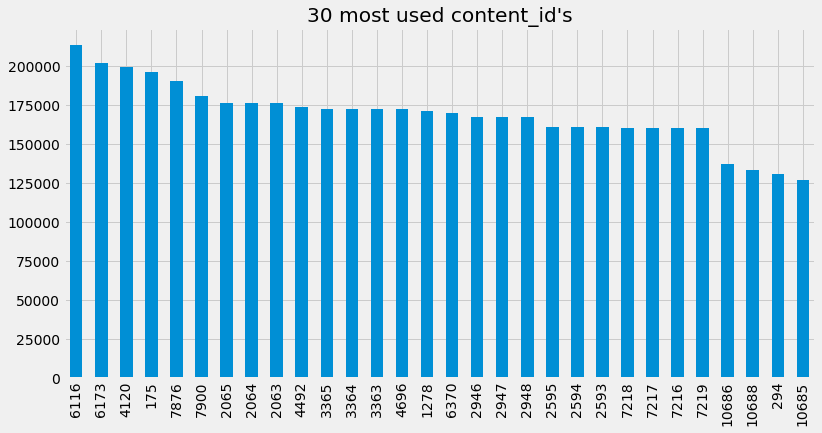

In [ ]:
cids = train.content_id.value_counts()[:30]
fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("30 most used content_id's")
plt.xticks(rotation=90)
plt.show()

In [ ]:
## task_container_id 변수 확인
print(f"task_container_id unique : {train.task_container_id.nunique()}")

task_container_id unique : 10000


In [ ]:
## User answer 변수 확인
train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

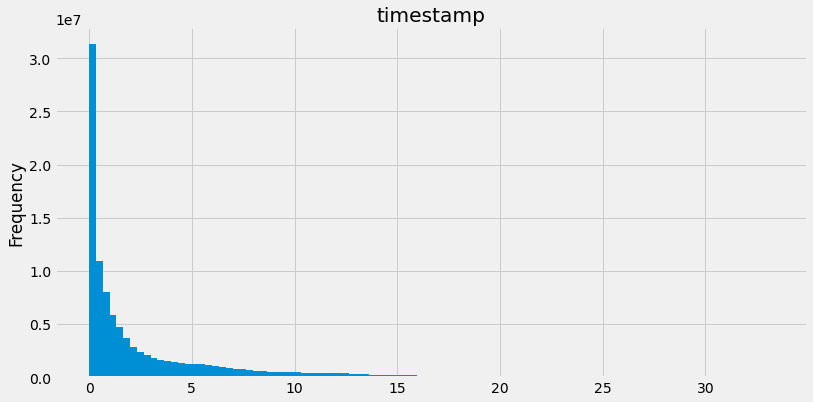

In [ ]:
## timestamp 변수 확인
ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("timestamp")
plt.show()

In [ ]:
# 모든 사용자의 이력을 가지고 있는지?
print(f"{train.user_id.nunique()}, {train[train.timestamp==0].nunique()}")

393656, row_id                            396417
timestamp                              1
user_id                           393656
content_id                          5281
content_type_id                        2
task_container_id                     16
user_answer                            5
answered_correctly                     3
prior_question_elapsed_time          382
prior_question_had_explanation         2
dtype: int64


In [ ]:
train.answered_correctly.value_counts()

 1    65244627
 0    34026673
-1     1959032
Name: answered_correctly, dtype: int64

In [ ]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

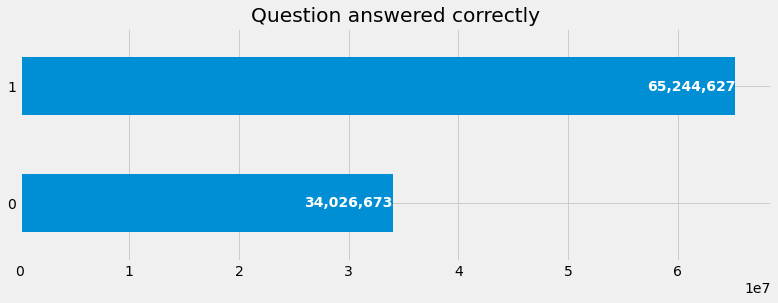

In [ ]:
fig = plt.figure(figsize = (12, 4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, "{:,}".format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Question answered correctly")
plt.xticks(rotation=0)
plt.show()

In [ ]:
#timestamp vs answered_correctly
#가입 기간이 길 수록 정답률도 높은 지
bin_labels_5 = ["Bin_1", "Bin_2","Bin_3","Bin_4","Bin_5"]
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)

In [ ]:
correct = train[train.answered_correctly!=-1].groupby(['ts_bin', 'answered_correctly'], as_index=False).size()
correct = correct.pivot('ts_bin', 'answered_correctly', 'size')

In [ ]:
correct

answered_correctly,0,1
ts_bin,,
Bin_1,8242434,11775731
Bin_2,6610350,13163765
Bin_3,6400898,13383654
Bin_4,6404411,13425334
Bin_5,6368580,13496143


In [ ]:
del correct
import gc
gc.collect()

9210

In [ ]:
def correct(field):
    correct = train[train.answered_correctly!=-1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index=field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1] / (correct.iloc[:,0] + correct.iloc[:,1]), 2)
    correct = correct.sort_values(by = "Percent_correct", ascending=False)
    correct = correct.iloc[:,2]
    return correct

In [ ]:
bins_correct = correct('ts_bin')
bins_correct = bins_correct.sort_index()
bins_correct

ts_bin
Bin_1    0.59
Bin_2    0.67
Bin_3    0.68
Bin_4    0.68
Bin_5    0.68
Name: Percent_correct, dtype: float64

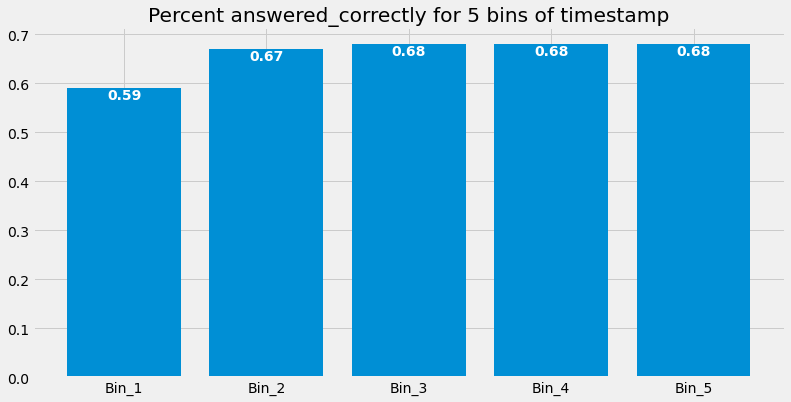

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va = 'top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp")
plt.show()

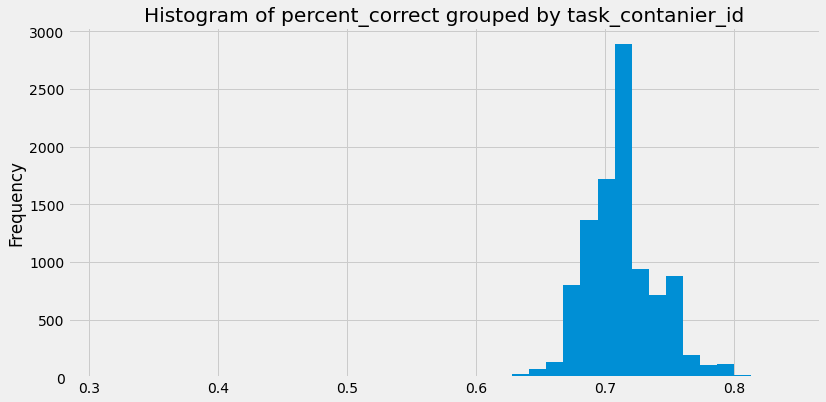

In [ ]:
## task container vs correctly_answered
task_id_correct = correct("task_container_id")
fig = plt.figure(figsize=(12, 6))
task_id_correct.plot.hist(bins=40)
plt.title(f"Histogram of percent_correct grouped by task_contanier_id")
plt.show()

In [ ]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
user_percent

,Mean,Answers
user_id,,
115,0.695652,46
124,0.233333,30
2746,0.578947,19
5382,0.672000,125
8623,0.642202,109
...,...,...
2147470770,0.765487,226
2147470777,0.691489,752
2147481750,0.760000,50


In [ ]:
user_percent[user_percent.Answers==17609]

,Mean,Answers
user_id,,
801103753,0.721109,17609


In [ ]:
user_percent.Answers.describe()

count    393656.000000
mean        252.177790
std         734.721108
min           1.000000
25%          30.000000
50%          40.000000
75%         154.000000
max       17609.000000
Name: Answers, dtype: float64

In [ ]:
user_percent.Answers.quantile(0.93)

836.0

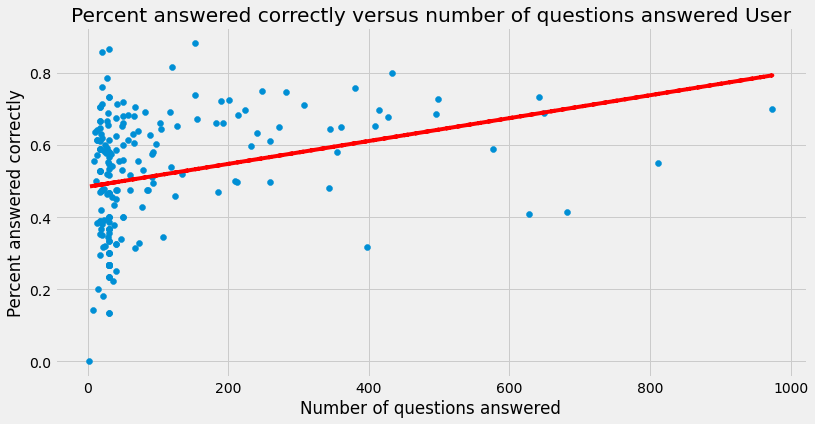

In [ ]:
## Number of answers VS answered correctly comparision
user_percent = user_percent.query('Answers < 1000').sample(n=200, random_state=1)
fig = plt.figure(figsize = (12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()
## 비례관계임을 알 수 있음

In [ ]:
## content id vs answered correctly
content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}')


The highest number of questions asked by content_id is 213605


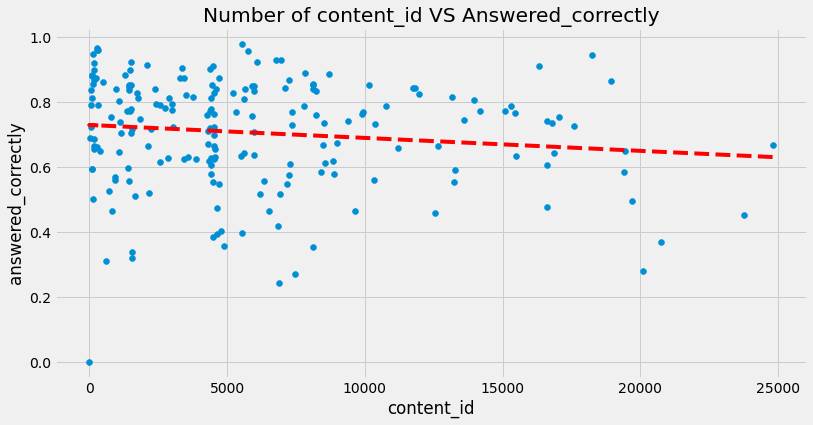

In [ ]:
## 반비례 관계
content_percent = content_percent.query("Answers <= 25000").sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Number of content_id VS Answered_correctly")
plt.xlabel("content_id")
plt.ylabel("answered_correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

prior_question_had_explanation
False     9193234
True     89685560
NaN        392506
Name: (answered_correctly, count), dtype: int64


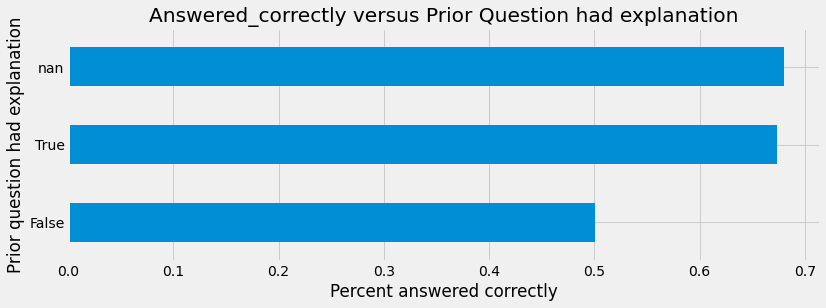

In [ ]:
## Answered_correctly vs Prior Question had explanation
# train.prior_question_had_explanation.value_counts()
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({"answered_correctly":['mean', 'count']})
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()

plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)
plt.show()

In [ ]:
pq = train[train.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly':['count'], 'prior_question_elapsed_time':['mean']})
pq

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,34026673,25641.991586
1,65244627,25309.977185


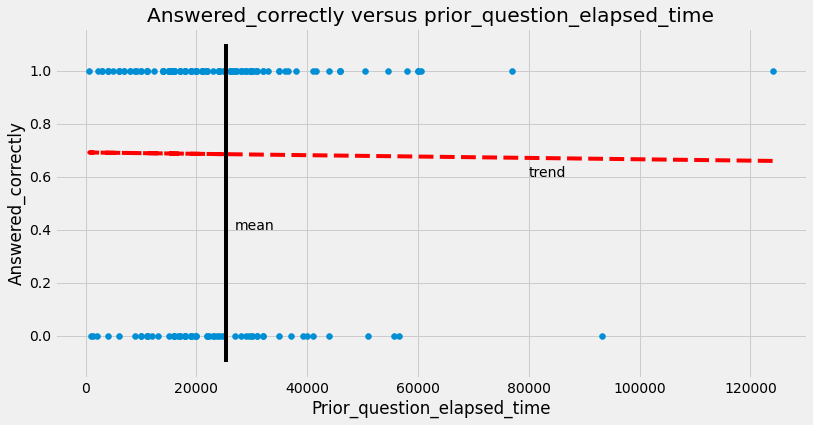

In [ ]:
mean_pq = train.prior_question_elapsed_time.astype("float64").mean()
condition = ((train.answered_correctly != -1)) & (train.prior_question_elapsed_time.notna())
pq = train[condition][['prior_question_elapsed_time', 'answered_correctly']].sample(n=200, random_state=1)
pq = pq.set_index('prior_question_elapsed_time').iloc[:,0]

fig = plt.figure(figsize=(12,6))
x = pq.index
y = pq.values
plt.scatter(x, y, marker='o')
plt.title("Answered_correctly versus prior_question_elapsed_time")
plt.xticks(rotation=0)
plt.xlabel("Prior_question_elapsed_time")
plt.ylabel("Answered_correctly")
plt.vlines(mean_pq, ymin=-0.1, ymax=1.1)
plt.text(x= 27000, y=0.4, s='mean')
plt.text(x=80000, y=0.6, s='trend')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

## Exploring Questions

In [ ]:
os.listdir()

['.config',
 'riid',
 'lectures.csv',
 'gdrive',
 'questions.csv',
 'kaggle.json',
 'train.csv.zip',
 'example_sample_submission.csv',
 '__init__.py',
 'example_test.csv',
 'competition.cpython-37m-x86_64-linux-gnu.so',
 'train.csv',
 'sample_data']

In [ ]:
questions = pd.read_csv('questions.csv')

In [ ]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [ ]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [ ]:
train.query('content_id == "10033" and answered_correctly != -1')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,ts_bin
62750278,62750278,1286282597,1333688829,10033,False,1127,2,1,35000.0,True,Bin_2


In [ ]:
# Right vs Wrong
questions['tags'] = questions['tags'].astype(str)
tags = [x.split() for x in questions[questions.tags != 'nan'].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f"There are {len(tags)} different tags")

There are 188 different tags


In [ ]:
# Let's find out how many answeres were Right and Wrong per question_id
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(['content_id', 'answered_correctly'], as_index=False).size()
correct = correct.pivot('content_id', 'answered_correctly', 'size')

correct.columns = ['Wrong', 'Right']
correct.fillna(0, inplace=True)

correct[['Wrong', 'Right']] = correct[['Wrong', "Right"]].astype(int)
questions = questions.merge(correct, left_on='question_id', right_on='content_id', how='left')
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


In [ ]:
%%time
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({"Wrong" : ['sum'], 'Right' : ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right / tags_df.Total_questions
tags_df.head()

CPU times: user 1.66 s, sys: 2.94 ms, total: 1.66 s
Wall time: 1.66 s


In [ ]:
tags_df.sort_values(by = 'Percent_correct', inplace=True)

In [ ]:
tags_df.head()

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,157631,98982,256613,17,0.385725
23,261611,204293,465904,11,0.438487
19,173602,136367,309969,57,0.439938
151,272267,264913,537180,16,0.493155
167,170386,170681,341067,11,0.500432


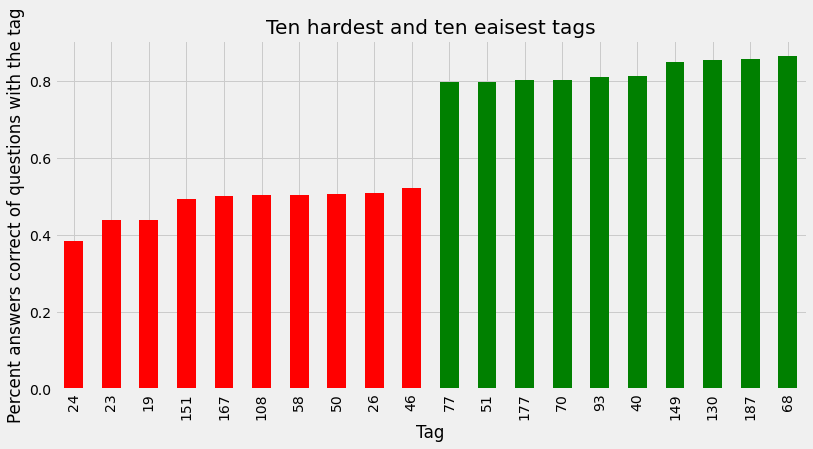

In [ ]:
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows, 4]

fig = plt.figure(figsize=(12, 6))
x = tags_select.index
y = tags_select.values

clrs = ['red' if y < 0.6 else 'green' for y in tags_select.values]

tags_select.plot.bar(x, y, color=clrs)
plt.title("Ten hardest and ten eaisest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct of questions with the tag")
plt.show()

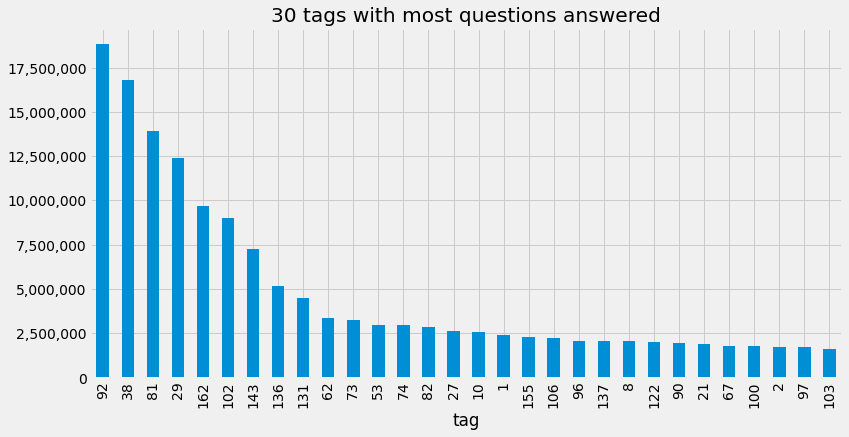

In [ ]:
tags_select = tags_df.sort_values(by = 'Total_questions', ascending=False).iloc[:30,:]
tags_select = tags_select['Total_questions']
fig = plt.figure(figsize=(12,6))
ax = tags_select.plot.bar()
plt.title("30 tags with most questions answered")
plt.xticks(rotation=90)
plt.ticklabel_format(style='sci', axis='y')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p : format(int(x), ',')))
plt.show()

In [ ]:
questions.head(5)

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


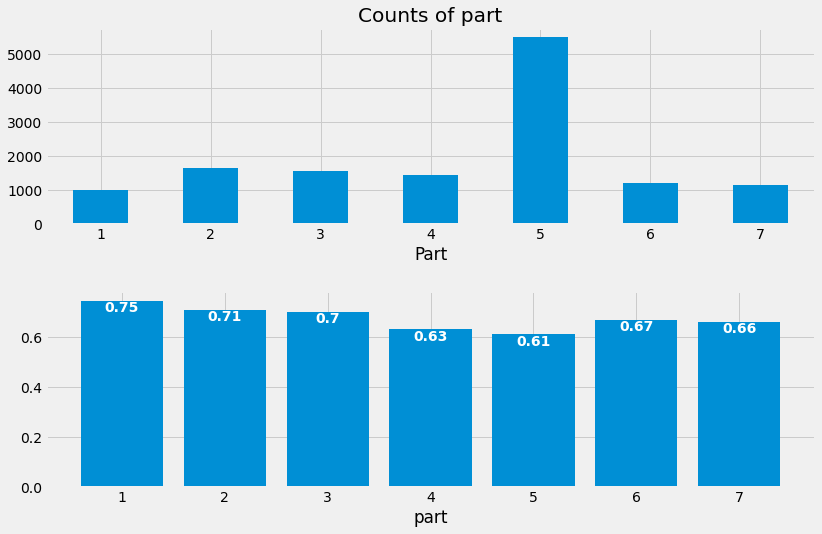

In [ ]:
## parts analysis
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax1 = questions.groupby('part').count()['question_id'].plot.bar()
plt.title("Counts of part")
plt.xlabel("Part")
plt.xticks(rotation=0)

#ax2 = fig.add_subplots(212)
part = questions.groupby('part').agg({'Wrong' : ['sum'], 'Right' : ['sum']})
part['Percent_correct'] = part.Right / (part.Right + part.Wrong)
part = part.iloc[:,2]

ax2 = fig.add_subplot(212)
plt.bar(part.index, part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, v, round(v,2), color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.xlabel("part")
plt.xticks(rotation=0)
plt.tight_layout(pad=2)
plt.show()


In [ ]:
## Exploring Lectures
lectures = pd.read_csv("lectures.csv")
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [ ]:
print(f'There are {lectures.shape[0]} lecutre_ids.')

There are 418 lecutre_ids.


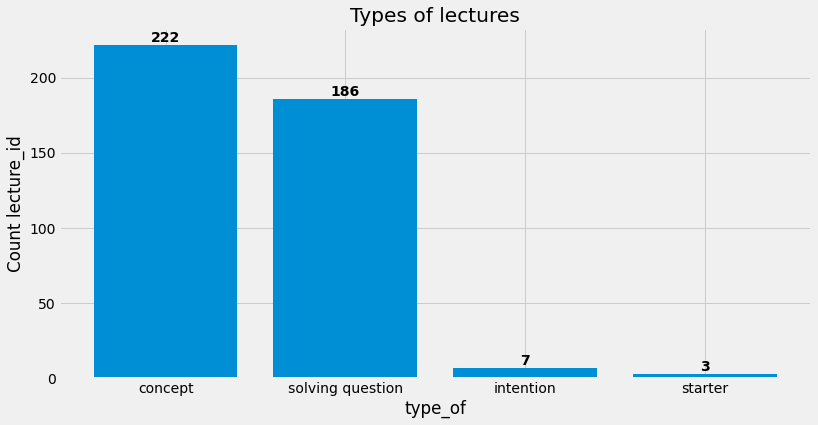

In [ ]:
lect_type_of = lectures.type_of.value_counts()
fig = plt.figure(figsize=(12, 6))
plt.bar(lect_type_of.index, lect_type_of.values)
for i, v in zip(lect_type_of.index, lect_type_of.values):
    plt.text(i, v, v, color='black', fontweight='bold', va='bottom', ha='center', fontsize=14)

plt.title("Types of lectures")
plt.xlabel("type_of")
plt.ylabel("Count lecture_id")
plt.xticks(rotation=0)
plt.show()

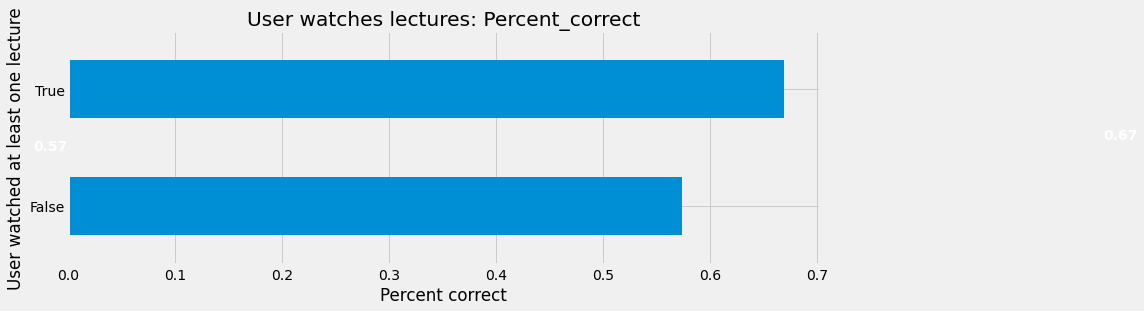

In [ ]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({"Wrong":['sum'], 'Right':['sum']})
watches_l['Percent_correct'] = watches_l.Right / (watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12, 4))
watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(i, v, round(v, 2), color='white', fontweight='bold', fontsize=14, ha='right', va='top')
plt.title("User watches lectures: Percent_correct")
plt.xlabel("Percent correct")
plt.ylabel("User watched at least one lecture")
plt.xticks(rotation=0)
plt.show()

In [ ]:
batch_lect = train.groupby(['task_container_id', 'answered_correctly']).size().unstack()
batch_lect.columns = ['Lecture', 'Wrong', 'Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect['Lecture'] = batch_lect.astype('Int64')
batch_lect["Percent_correct"] = batch_lect.Right / (batch_lect.Right + batch_lect.Wrong)
batch_lect["Percent_lecture"] = batch_lect.Lecture / (batch_lect.Right + batch_lect.Wrong + batch_lect.Lecture)
batch_lect = batch_lect.sort_values(by='Percent_lecture', ascending=False)

print(f"The highest container_batch is {batch_lect['Lecture'].max()}")



The highest container_batch is 5143


In [ ]:
batch_lect.head()

,Lecture,Wrong,Right,Percent_correct,Percent_lecture
task_container_id,,,,,
9096,8,57.0,191.0,0.770161,0.03125
270,2265,26105.0,52352.0,0.667270,0.0280593
477,1428,16166.0,33427.0,0.674027,0.0279885
253,2343,27380.0,54798.0,0.666821,0.0277209
351,1835,21225.0,43158.0,0.670332,0.0277115


Text(0, 0.5, 'Percent_correct')

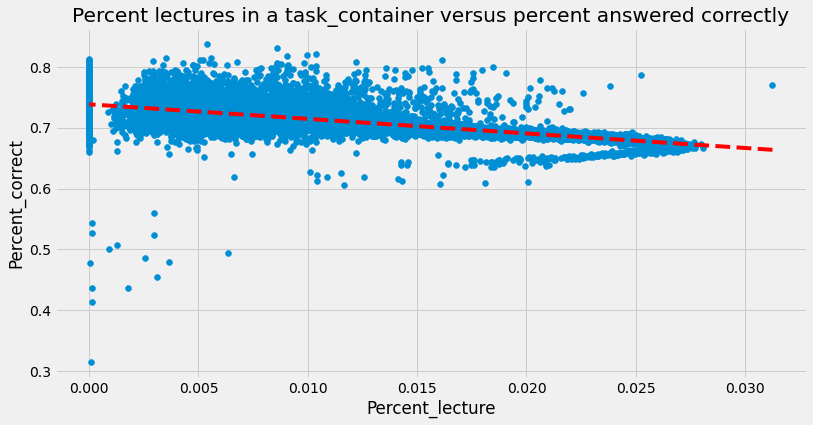

In [ ]:
# Percent Lecture vs Percent correct
batch = batch_lect.iloc[:, 3:]
fig = plt.figure(figsize=(12, 6))
x = batch.Percent_lecture.astype('float').values
y = batch.Percent_correct.astype('float').values

z = np.polyfit(x, y, 1)
p = np.poly1d(z)



plt.scatter(x, y, marker='o')
plt.plot(x, p(x), 'r--')
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent_lecture")
plt.ylabel("Percent_correct")


In [ ]:
# Has lecture vs else
batch_lect['Has_lecture'] = np.where(batch_lect.Lecture == 0, False, True)
print(f"{batch_lect[batch_lect['Has_lecture']==False].shape[0]}, {batch_lect[batch_lect['Has_lecture']==True].shape[0]}")

631, 9369


In [ ]:
batch_lect_stat = batch_lect[["Wrong", "Right", "Has_lecture"]]
batch_lect_stat = batch_lect_stat.groupby("Has_lecture").sum()
batch_lect_stat['Percent_lecture'] = batch_lect_stat.Right / (batch_lect_stat.Right + batch_lect_stat.Wrong)
batch_lect_stat[['Percent_lecture']]

,Percent_lecture
Has_lecture,
False,0.736412
True,0.657087


In [ ]:
#Example Test
example_test = pd.read_csv("example_test.csv")
example_test

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
99,104,3,13167339284,1900527744,3004,0,1179,24667.0,True,NaN,NaN
100,105,3,13167339284,1900527744,3003,0,1179,24667.0,True,NaN,NaN
101,106,3,64497673060,7792299,7908,0,676,19000.0,True,NaN,NaN
102,107,3,62798166743,288641214,9077,0,269,25000.0,True,NaN,NaN


In [ ]:
batches_test = set(list(example_test.task_container_id.unique()))
batches_train = set(list(train.task_container_id.unique()))
print(batches_test.issubset(batches_train))

True


In [ ]:
user_id_test = set(list(example_test.user_id))
user_id_train = set(list(train.user_id))
print(user_id_test - user_id_train)

{275030867}


In [ ]:
### BaseLine Model
### Clear everything loaded except libraries
%reset -f

In [ ]:
import os
os.listdir()

['.config',
 'competition.cpython-37m-x86_64-linux-gnu.so',
 'riiideducation',
 'questions.csv',
 'train.csv',
 'gdrive',
 'example_test.csv',
 'lectures.csv',
 'example_sample_submission.csv',
 'riid',
 'kaggle.json',
 'train.csv.zip',
 'riideducation',
 '__init__.py',
 'sample_data']

In [ ]:
os.makedirs("riiideducation", exist_ok=True)
!cp __init__.py riideducation
!cp competition.cpython-37m-x86_64-linux-gnu.so riideducation

In [ ]:
import numpy as np
import pandas as pd
import riiideducation
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gc
import sys
# pd.set_option('display.max_rows', None)

In [ ]:
# Train load
%%time
cols_to_load = ['timestamp', 'user_id', 'answered_correctly', 'content_id',
                'prior_question_had_explanation', 'prior_question_elapsed_time']
train = pd.read_csv("train.csv")[cols_to_load]
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')
print(f"Train size:{train.shape}") 

Train size:(101230332, 7)
CPU times: user 1min 14s, sys: 26.4 s, total: 1min 41s
Wall time: 1min 48s


In [ ]:
%%time
questions = pd.read_csv('questions.csv')
lectures = pd.read_csv('lectures.csv')
example_test = pd.read_csv("example_test.csv")
example_sample_submission = pd.read_csv("example_sample_submission.csv")

CPU times: user 14.4 ms, sys: 6.16 ms, total: 20.6 ms
Wall time: 31.5 ms


In [ ]:
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({"answered_correctly" : ['count', 'mean']})

In [ ]:
## Adding user features
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({"answered_correctly" : ['count', 'mean']}).reset_index()
user_df.columns = ['user_id', 'user_questions', 'user_mean']

user_lect = train.groupby(['user_id', 'answered_correctly']).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', "Right"]
user_lect["Lecture"] = user_lect["Lecture"].fillna(0)
user_lect = user_lect.astype("Int64")
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, 1, 0)
user_lect = user_lect.reset_index()
user_lect = user_lect[['user_id', 'watches_lecture']]

user_df = user_df.merge(user_lect, on='user_id', how='left')
del user_lect
user_df.head()

,user_id,user_questions,user_mean,watches_lecture
0,115,46,0.695652,0
1,124,30,0.233333,0
2,2746,19,0.578947,1
3,5382,125,0.672000,1
4,8623,109,0.642202,1


In [ ]:
## adding content_feature
content_df = train[train.answered_correctly != -1].groupby('content_id').agg({'answered_correctly':['count','mean']}).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']

In [ ]:
## adding prior question information
## pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({"answered_correctly" : ['mean'], ['count']})
## pq = pq.iloc[:, 0]


In [ ]:
mean_prior = train.prior_question_elapsed_time.astype('float64').mean()

In [ ]:
# Bin information add
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)


def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'user_id','answered_correctly'], as_index=False).size()
    correct = correct.pivot(index = [field,'user_id'], columns='answered_correctly', values='size')
    correct['Bin_Percent_correct'] = round(correct.iloc[:,1] / (correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.iloc[:,2].reset_index()
    return correct

bins_correct = correct('ts_bin')
#bins_correct = bins_correct.to_dict()
#train['ts_bin_acc'] = train['ts_bin'].apply(bins_correct)

In [ ]:
train = train.merge(bins_correct, how='left', on=['ts_bin','user_id'])

In [ ]:
# Prior question had explanation -> 이미 반영되어 있음
# Prior question elapsed time -> 의미 없음


In [ ]:
# Questions check
os.listdir()
questions = pd.read_csv("questions.csv")

In [ ]:
questions['tags'] = questions['tags'].astype(str)
tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)

In [ ]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list

correct = train[train.answered_correctly != -1].groupby(["content_id", "answered_correctly"], as_index=False).size()
correct = correct.pivot("content_id", "answered_correctly", "size")
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on="question_id", right_on="content_id", how='left')
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


In [ ]:
## Tag information
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l : tags[x] in l)]
    df1 = df.agg({"Wrong" : ['sum'], "Right" : ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[["Wrong", "Right", "Total_questions"]] = tags_df[['Wrong', "Right", "Total_questions"]].astype(int)
tags_df["Tags_Percent_correct"] = tags_df.Right / tags_df.Total_questions
#tags_df = tags_df.reset_index()
tags_df = tags_df.sort_values(by = "Tags_Percent_correct")
tags_df.head()

,Wrong,Right,Total_questions,Question_ids_with_tag,Tags_Percent_correct
tag,,,,,
24,157631,98982,256613,17,0.385725
23,261611,204293,465904,11,0.438487
19,173602,136367,309969,57,0.439938
151,272267,264913,537180,16,0.493155
167,170386,170681,341067,11,0.500432


In [ ]:
tags_df = tags_df.reset_index()
#tags_df['tag'] = tags_df['tag']
tag_percent_dict = tags_df[['tag', 'Tags_Percent_correct']].set_index('tag').to_dict()

In [ ]:
def tag_to_question(tags):
    sum = 0
    try:
      for x in tags:
          sum += tag_percent_dict["Tags_Percent_correct"][x]
      return sum / len(tags)
    except:
        return 0

questions["Tag_Percent_Correct"] = questions['tags'].apply(tag_to_question)

In [ ]:
## part별 정확도 및 part 대비 그사람의 정확도
train.head()

,timestamp,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,ts_bin,Bin_Percent_correct
0,0,0,115,1,5692,<NA>,NaN,Bin_1,0.72
1,56943,1,115,1,5716,False,37000.0,Bin_1,0.72
2,118363,2,115,1,128,False,55000.0,Bin_1,0.72
3,131167,3,115,1,7860,False,19000.0,Bin_1,0.72
4,137965,4,115,1,7922,False,11000.0,Bin_1,0.72


In [ ]:
## 먼저 part별 정확도 부터 산출
part = questions.groupby('part').agg({"Wrong":['sum'], 'Right':['sum']})

In [ ]:
part['Part_correct'] = part.Right / (part.Right + part.Wrong)
part = part.iloc[:,2]

In [ ]:
questions['Part_correct'] = questions['part'].map(part.to_dict())

In [ ]:
train = train.merge(questions[['question_id', 'part', 'Part_correct']], left_on = 'content_id', right_on = 'question_id', how='left')
del train['question_id']

In [ ]:
train.head()

,timestamp,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,ts_bin,Bin_Percent_correct,part,Part_correct
0,0,0,115,1,5692,<NA>,NaN,Bin_1,0.72,5.0,0.610088
1,56943,1,115,1,5716,False,37000.0,Bin_1,0.72,5.0,0.610088
2,118363,2,115,1,128,False,55000.0,Bin_1,0.72,1.0,0.745032
3,131167,3,115,1,7860,False,19000.0,Bin_1,0.72,1.0,0.745032
4,137965,4,115,1,7922,False,11000.0,Bin_1,0.72,1.0,0.745032


In [ ]:
train['part'] = train['part'].astype("Int64")

In [ ]:
train_for_part = train[['user_id','part','answered_correctly']]

In [ ]:
import gc
gc.collect()

289

In [ ]:
## part별 개인 정답률 산출
user_part = train_for_part[train_for_part.answered_correctly != -1].groupby(['user_id','part'])['answered_correctly'].mean()
#train['Ind_part_correct'] =

user_part = user_part.reset_index()

user_part['part'] = user_part['part'].astype("Int64")

user_part = user_part.rename(columns={"answered_correctly":"part_answered_correctly"})

user_part

In [ ]:
train = train.merge(user_part[['user_id','part','part_answered_correctly']], on=['user_id','part'])

In [ ]:
gc.collect()
train.head()

,timestamp,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,ts_bin,Bin_Percent_correct,part,Part_correct,part_answered_correctly
0,0,0,115,1,5692,<NA>,NaN,Bin_1,0.72,5,0.610088,1.000000
1,56943,1,115,1,5716,False,37000.0,Bin_1,0.72,5,0.610088,1.000000
2,118363,2,115,1,128,False,55000.0,Bin_1,0.72,1,0.745032,0.702703
3,131167,3,115,1,7860,False,19000.0,Bin_1,0.72,1,0.745032,0.702703
4,137965,4,115,1,7922,False,11000.0,Bin_1,0.72,1,0.745032,0.702703


In [ ]:
del user_part
gc.collect()

122

In [ ]:
## 10기가 사용 중
train.memory_usage()

Index                             799751352
timestamp                         799751352
row_id                            799751352
user_id                           799751352
answered_correctly                799751352
content_id                        799751352
prior_question_had_explanation    199937838
prior_question_elapsed_time       799751352
ts_bin                             99969119
Bin_Percent_correct               799751352
part                              899720271
Part_correct                      799751352
part_answered_correctly           799751352
dtype: int64